In [169]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime

# Exploring Price Data
## Notebook Objective
The purpose of this project is to predict the price to hire a space for an event in London based on the characteristics of that space e.g. location, area, facilities etc. In order to do this, we have scraped all London based venues (and the event spaces within them) from the Tagvenue website. We will then use this data to model the prices. The price data is relatively complicated because there are multiple different price types (e.g. 'Hire Fee', 'Minimum Spend', 'Per person' etc.) and each venue or space uses different combinations of these price types e.g. one may use just 'hire fee' and another may use 'minimum spend' and 'per person'. Furthermore, each price type can vary on different days of the week, e.g. the 'hire fee' may be more on a Saturday than on a Monday.  

The Objective of this notebook is to explore the cleaned venue Prices data to determine: 
- What price types we will regress
- How we will regress these price types e.g. separate models or is there a way to convert a 'hire fee' to a 'minimum spend' and use a single model? 
- How we will deal with the variation in pricing on different weekdays

## Setup

In [170]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 0

## Importing Data
Below we import the cleaned prices data as dataframes. Metadata for these tables can be found in the repo Readme. 

In [356]:
prices = pd.read_csv('../data/cleaned_data/tag_venue_space_prices_25-Aug-22.csv')
venues = pd.read_csv('../data/cleaned_data/tag_venue_space_data_25-Aug-22.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/cleaned_data/tag_venue_space_prices_25-Aug-22.csv'

## Confirming Pricing Structure
Before we start, we want to check that we understand how the prices are structured in the data. We know the prices vary per space and per day of week and per price type (e.g. min. spend). We want to check whether there are any other variables that define the pricing. Below, we group the prices as described above and count the number of members of each group. We anticipate that there should be just one price per group i.e. these variables uniquely define each row in the data set. 

In [310]:
assumed_grouping = prices.groupby(['space_url', 'day_of_week', 'price_type'])
# count number of members in each group
count_per_group = assumed_grouping['total_price'].agg('count')

count_per_group.value_counts()

1    28820
2     6899
3     2139
4      648
5       12
7        7
Name: total_price, dtype: int64

We anticipated that a value count would return a single row i.e. all groups would have size 1. Clearly that is not the case, we see that using our grouping we are not always defining individual prices but are sometimes defining groups of prices, up to 7 in a group. 

The above analysis showed that there are more factors that define each price in the dataset than 'space_url', 'day_of_week' and 'price_type'. We did some exploring of the data and realised that 'pricing_period', the column that verbally describes a time period e.g. 'all day' or 'per hour' was also used to define prices. For example, a space may have multiple prices on a Monday that are 'hire fee' price types. The 2 prices are differentiated by their time period descriptions. One may be the price 'per hour' and the other is the price for 'all day'.

Below we will quantify the fraction of the prices and spaces that use pricing_period to define different prices. Note that from the value count above, we know that 28820 prices are not defined by pricing period, and thus we can simply subtract this from the total number of prices to get the number of prices that are defined by pricing period: 

In [315]:
total_prices = prices.shape[0]
# subtract the first row of value count above from all price data count
num_prices_using_period = total_prices - 28820

# get access to multi index columns  
count_per_group = count_per_group.reset_index()
# gets space urls of all spaces that used pricing period to define prices
urls_using_pricing_period = count_per_group[
    count_per_group.total_price > 1
].space_url

num_spaces_using_period = urls_using_pricing_period.nunique()
total_spaces = prices.space_url.nunique()

print(f"{num_prices_using_period} prices out of {total_prices} total prices -> {num_prices_using_period / total_prices:.0%}")
print(f"{num_spaces_using_period} spaces out of {total_spaces} total spaces -> {num_spaces_using_period / total_spaces:.0%}")

22916 prices out of 51736 total prices -> 44%
1569 spaces out of 4761 total spaces -> 33%


We can see that one third of all spaces have used pricing period to define their prices and 44% of our data is defined by the pricing period. We clearly need to include pricing period in our exploration and must figure out how it will impact our regression approach.

To make sure that pricing period is the only variable we were missing, we will repeat the above and group the data according to the 4 columns we have identified and see if these uniquely define each price: 

In [317]:
assumed_grouping = prices.groupby(['space_url', 'day_of_week', 'pricing_period', 'price_type'])
# count number of members in each group
count_per_group = assumed_grouping['total_price'].agg('count')

count_per_group.value_counts()

1    45058
2     2613
3      414
4       42
6        7
Name: total_price, dtype: int64

Once again, we find that there is another variable that defines prices. Some more exploring found that the actual time period itself e.g. '12:00 - 14:00' could also define separate prices in the data as shown below: 

![alt text](../images/tag_venue_pricing_period.png)

As before, we will quantify the number of spaces and prices that are defined in this way: 

In [318]:
# subtract the first row of value count above from all price data count
num_prices_using_period = total_prices - 45058

# get access to multi index columns  
count_per_group = count_per_group.reset_index()
# gets space urls of all spaces that used pricing period to define prices
urls_using_pricing_period = count_per_group[
    count_per_group.total_price > 1
].space_url

num_spaces_using_period = urls_using_pricing_period.nunique()

print(f"{num_prices_using_period} prices out of {total_prices} total prices -> {num_prices_using_period / total_prices:.0%}")
print(f"{num_spaces_using_period} spaces out of {total_spaces} total spaces -> {num_spaces_using_period / total_spaces:.0%}")

6678 prices out of 51736 total prices -> 13%
511 spaces out of 4761 total spaces -> 11%


We can see its a much smaller amount of data that is priced in this way, only 11% of spaces and 13% of the price data. We will need to investigate the actual pricing time periods as well and see how they impact the prices and our regression.

We will once again repeat the grouping analysis, this time using all 5 variables identified and see if they uniquely define all prices. We need to create the time period shown as start to end time e.g. '9 - 12' as a new column. 

In [325]:
prices['time_string'] = (prices.time_from.astype(str) + ' - ' 
                         + prices.time_to.astype(str)
                    )

assumed_grouping = prices.groupby(['space_url', 'day_of_week', 'pricing_period', 
                                   'price_type', 'time_string'])
# count number of members in each group
count_per_group = assumed_grouping['total_price'].agg('count')

count_per_group.value_counts()

1    51736
Name: total_price, dtype: int64

The above shows that the 5 columns 'space_url', 'day_of_week', 'pricing_period', 'price_type' and 'time_string' uniquely define every price in the prices data. We will now explore each variable individually to understand how we might approach our regression of prices. 
### Expanded Objectives
Our objectives have expanded with the new information. We now aim to determine:

-  What combinations of price type and pricing periods (descriptions and actual times) we will regress
- How we will regress these price types and time periods e.g. separate models or is there a way to convert a 'hire fee' to a 'minimum spend' and use a single model?
- How we will deal with the variation in pricing at different times
- How we will deal with the variation in pricing on different weekdays

## Exploring Price Type
### Basic Breakdown
We will start by analysing the price types used in the data in isolation i.e. ignoring weekdays and pricing period. We will remove the weekday and pricing period data by removing duplicates on the space_url (which acts as a unique key for an event space) and price_type columns. In the resulting dataset, each space will contribute one row per price type it uses e.g. if a space uses 3 price types, then in the dataset it will have 3 rows, one for each price type. We perform a simple value count showing the percentage frequency of each price_type in the data:

In [172]:
price_types_per_space = prices.drop_duplicates(['space_url','price_type'])
price_types_per_space['price_type'].value_counts(True)*100

hire fee                 32.073628
min. spend               30.200358
hire fee per hour        18.211435
per person               15.702883
hire fee + min. spend     3.420753
hire fee + per person     0.390943
Name: price_type, dtype: float64

Below we will also show the raw counts per price type: 

In [173]:
price_types_per_space['price_type'].value_counts()

hire fee                 1969
min. spend               1854
hire fee per hour        1118
per person                964
hire fee + min. spend     210
hire fee + per person      24
Name: price_type, dtype: int64

**Observations**: 
- **hire fee** and **min. spend** account for approximately 60% of the data alone.
- The top 4 price types **hire fee**, **min. spend**, **hire fee per hour** and **per person** all have around 1000 observations or more each, meaning they would have a fairly good amount of data if separate models were built for each price type. 
- The combined price types **hire fee + min. spend** and **hire fee + per person** account for a tiny percent of the data (only ~4%) and we are not particularly interested in predicting these kind of prices, so we will likely exclude them from the scope of modeling. 

The above data is for all spaces in all venues. We would also like to see how the price type is broken down between venues i.e. ignoring differences in price type between different spaces in a venue. To do this, we  will remove duplicates on the **venue_url** and **price_type** columns. In the resulting dataset, each venue will contribute one row per price type it uses e.g. if across all 4 spaces of a venue, the venue used 3 price types, then in the dataset it will have 3 rows, one for each price type. 

In [174]:
price_types_per_venue = prices.drop_duplicates(['venue_url','price_type'])

price_types_per_venue.price_type.value_counts(True)*100

min. spend               31.601563
hire fee                 29.609375
hire fee per hour        21.914062
per person               12.421875
hire fee + min. spend     3.984375
hire fee + per person     0.468750
Name: price_type, dtype: float64

In [175]:
price_types_per_venue.price_type.value_counts()

min. spend               809
hire fee                 758
hire fee per hour        561
per person               318
hire fee + min. spend    102
hire fee + per person     12
Name: price_type, dtype: int64

**Observations:**
- Again, the combined price types ('hire fee + min. spend' and 'hire fee + per person') are rare, only accounting for ~4.5% of the data
- The frequency breakdowns and order of the most common price types is the same as when analysed on a per space basis, suggesting that venues typically use the same price types for all their spaces.

### Price Type Overlap
We know the relative frequency of the price types in the data. We now want to breakdown spaces by the combination of price types they use e.g. how many spaces use just 'hire fee'. How many spaces use 'Hire fee' and 'minimum spend'. This data will help us understand how much overlap there is between different price types. This may allow us to derive a conversion equation e.g. convert hire fee to min spend. It will also help us understand what fraction of event spaces would be excluded from our models if we choose to exclude certain price types. For example, perhaps min. spend is used by most of the event spaces that use 'per person'. In this case, maybe we can simply regress 'min. spend' and exclude 'per person' and we will still be including most of the event spaces available in our model. 

In [176]:
# Convert price_types_per_space df to being price types grouped 
# per space (space_url) 
price_types_per_space = price_types_per_space.groupby(['space_url'], 
                                                      as_index = False)
# Concatenates price types together into single string per space url
price_types_per_space = price_types_per_space['price_type'].agg(' - '.join)
price_types_per_space.sample(10)

,space_url,price_type
839,https://www.tagvenue.com/rooms/london/15427/hi...,per person
658,https://www.tagvenue.com/rooms/london/1443/41-...,hire fee
3013,https://www.tagvenue.com/rooms/london/32379/no...,min. spend
1948,https://www.tagvenue.com/rooms/london/23371/th...,hire fee per hour - hire fee
1177,https://www.tagvenue.com/rooms/london/18299/tr...,per person
2955,https://www.tagvenue.com/rooms/london/31630/th...,hire fee + per person
2019,https://www.tagvenue.com/rooms/london/2423/can...,min. spend
3560,https://www.tagvenue.com/rooms/london/38550/cr...,hire fee per hour - hire fee
3991,https://www.tagvenue.com/rooms/london/5410/lov...,min. spend
1598,https://www.tagvenue.com/rooms/london/21282/go...,hire fee - per person


**price_types_per_space** now contains 1 row per event space and in the **price_type** column it has combined all price types used by that event space into a single string e.g. if a venue used 'hire fee' and 'min. spend' then it would have 'hire fee - min. spend' in the **price_type** column. We will now perform a value count on this to get the relative number of event spaces using different combinations of price types. We will plot this as well. 

In [177]:
price_type_counts = price_types_per_space.price_type.value_counts()
# Use index (price type) as column to make ploting easier
price_type_counts = price_type_counts.reset_index()
price_type_counts

,index,price_type
0,min. spend,1483
1,hire fee,905
2,hire fee per hour - hire fee,591
3,per person,492
4,hire fee per hour,442
5,hire fee - per person,252
6,hire fee + min. spend,144
7,min. spend - per person,124
8,hire fee - min. spend,113
9,hire fee - min. spend - per person,51


/opt/homebrew/Caskroom/miniforge/base/envs/venue-scrape2/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



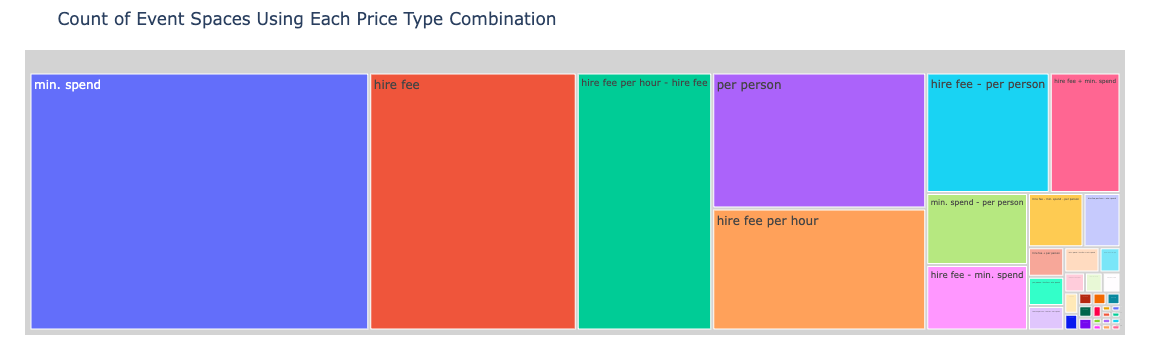

In [348]:
fig = px.treemap(price_type_counts, path=['index'], values='price_type', 
                 title = 'Count of Event Spaces Using Each Price Type Combination')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

To recap, the above plot has taken every single event space and categorised it according to what price types it uses. For example, if an event space only used 'min. spend' then it would be categorised as 'min. spend'. If an event space used both 'hire fee' and 'min. spend' then it would be categorised as 'hire fee - min. spend'. So the plot shows the number of event spaces that use each combination of price types (and an event space can only belong to one category i.e. the total count of all categories is the total number of event spaces). Each area represents a fraction of the total number of event spaces e.g. the blue box called 'min. spend' is showing that 1483 of the event spaces use just 'min. spend' and this is the most common pricing structure. 

**Observations:**
- When we looked at raw counts of price types, we found that hire fee was the most common, followed by min. spend. Here we see that minimum spend occurs alone more often than hire fee does. 
- The bulk of hire fee event spaces are split between hire fee alone (red) and hire fee combined with hire fee per hour (green). This suggests we could ignore hire fee per hour and just regress hire fee, and we would still capture both the red and green areas. 
- We may also be able to derive an equation to convert hire fee to hire fee per hour using this overlap. This would allow us to include the orange chunk (hire fee per hour) without needing to create a separate model for hire fee per hour. 
- Per person and hire fee (light blue) also have an overlap which could be used to derive an equation as above and potentially combine them.

### Conclusions
- **Hire Fee** and **Min. Spend** have the most observations to use for modeling.
- The majority of spaces use a single price type. If they use multiple price types, they generally will use no more than 2. 
- Due to the small number of spaces that use the combined price types **'hire fee + min. spend** and **hire fee + per person** we will not probably not attempt to regress these price types.


## Big Questions: 
- Link between per session, per day and per evening and the related times e.g. length and actual start and end times....what is per session? Tpyical start time? tyopical end time? That versus per day? and per evening? 
- breakdown of per period stuff and price type -> thats a biggy!
- Variation in prices at different times and with different time periods...can we even tell the later?


blurg

- Per session and per evening...same or different? Can we combine? How to tell...the time period?
- breakdown of time period description and specific times and specific lengths of time
- need to clearly define time period, time string and time passed...add in text and keep!
- Do prices vary for different time periods? Do they vary for different time lengths? Do they vary for different times of day? 
- What is typical length of session? Of evening? Are they same? What about if they are at the same time? How to check...data oif breakdowns...probably best and then do actual regression....

General Approach: 
- Is combining certain price types / categories viable? One answer is simply to build model using both and see if its better than individual! proof is in the pudding! That could be best answer to combining pricing periods and to combining hire fee and min. spend etc. although there are perhaps other ways to check and maybe I should try with price type data as below: 
  - Check overlapped data for whether prices are same or different 

- I'm thinking best approach is: 
  - Look at individual breakdowns and combned breakdowns 
  - figue out how you would combine e.g. duplicated prices? How problematic? 
  - Look at sizes of number of observations, need to be large enough 
  - identify tyopically joined or sepatrasted 
  - test different combinations in actual models - thats the best way to check! 

## Exploring Pricing Period
We will now explore pricing period in isolation i.e. ignoring weekdays and price types. 
### Re-Defining Time Period Columns
To avoid confusion, we will rename the price period related columns as below: 

|Old Column Name|New Column Name|Description|
|:---|:---|:---|
|pricing_period|price_period_desc|Description of pricing period e.g. 'per morning' or 'per day'|
|time_string|price_period|String defining the start and end time of the pricing period. It has the format 'start time - end time' and the times are written in integer format e.g. '6 - 17' means start time 6 am till end time 5 pm.|

**Please Note ->** From now on, when we refer to price period, we are referring to the price_period column i.e. the start and finish time e.g. '14 - 18' (in integer format as described in the table). When we refer to price period description, we are referring to the price_period_desc column e.g. 'per day' or 'per session'.

In [354]:
prices = prices.rename({'pricing_period': 'price_period_desc', 
               'time_string': 'price_period'})

In [355]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 0 to 51735
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   space_url         51736 non-null  object 
 1   venue_url         51736 non-null  object 
 2   venue_name        51736 non-null  object 
 3   space_name        51736 non-null  object 
 4   latitude          51736 non-null  float64
 5   longitude         51736 non-null  float64
 6   day_of_week       51736 non-null  object 
 7   pricing_period    51736 non-null  object 
 8   time_from         51736 non-null  float64
 9   time_to           51736 non-null  float64
 10  time_period       51736 non-null  float64
 11  total_price       51736 non-null  float64
 12  price_type        51736 non-null  object 
 13  rent_price_split  2434 non-null   float64
 14  min_spend_split   0 non-null      float64
 15  per_person_split  2434 non-null   float64
 16  time_string       51736 non-null  object

### Basic Breakdown
We will initially focus on the price_period_desc column because it is used to define more prices than the price_period column. We will remove duplicates on the 'space_url' and 'price_period_desc' column to remove the weekday and price_period data. This dataset will have one row for each price period description associated with each venue space. E.g. if a event space uses 2 price period descriptions to define its prices, then it will have 2 rows in the data set. 

In [350]:
price_period_desc_per_space = prices.drop_duplicates(['space_url','price_period_desc'])
price_period_desc_per_space['price_period_desc'].value_counts(True)*100

KeyError: Index(['price_period_desc'], dtype='object')

Below we will also show the raw counts per price type: 

In [338]:
price_period_desc_per_space['price_period_desc'].value_counts()

Per day          2275
Per session      1767
Per evening      1271
Per hour         1118
Per afternoon     595
Per morning       378
Name: pricing_period, dtype: int64

**Observations**: 
- **hire fee** and **min. spend** account for approximately 60% of the data alone.
- The top 4 price types **hire fee**, **min. spend**, **hire fee per hour** and **per person** all have around 1000 observations or more each, meaning they would have a fairly good amount of data if separate models were built for each price type. 
- The combined price types **hire fee + min. spend** and **hire fee + per person** account for a tiny percent of the data (only ~4%) and we are not particularly interested in predicting these kind of prices, so we will likely exclude them from the scope of modeling. 

The above data is for all spaces in all venues. We would also like to see how the price type is broken down between venues i.e. ignoring differences in price type between different spaces in a venue. To do this, we  will remove duplicates on the **venue_url** and **price_type** columns. In the resulting dataset, each venue will contribute one row per price type it uses e.g. if across all 4 spaces of a venue, the venue used 3 price types, then in the dataset it will have 3 rows, one for each price type. 

**Observations:**
- Again, the combined price types ('hire fee + min. spend' and 'hire fee + per person') are rare, only accounting for ~4.5% of the data
- The frequency breakdowns and order of the most common price types is the same as when analysed on a per space basis, suggesting that venues typically use the same price types for all their spaces.

### Price Type Overlap
We know the relative frequency of the price types in the data. We now want to breakdown spaces by the combination of price types they use e.g. how many spaces use just 'hire fee'. How many spaces use 'Hire fee' and 'minimum spend'. This data will help us understand how much overlap there is between different price types. This may allow us to derive a conversion equation e.g. convert hire fee to min spend. It will also help us understand what fraction of event spaces would be excluded from our models if we choose to exclude certain price types. For example, perhaps min. spend is used by most of the event spaces that use 'per person'. In this case, maybe we can simply regress 'min. spend' and exclude 'per person' and we will still be including most of the event spaces available in our model. 

In [339]:
# Convert price_types_per_space df to being price types grouped 
# per space (space_url) 
price_period_desc_per_space = price_period_desc_per_space.groupby(['space_url'], 
                                                      as_index = False)
# Concatenates price types together into single string per space url
price_period_desc_per_space = price_period_desc_per_space['price_period_desc'].agg(' - '.join)
price_period_desc_per_space.sample(10)

,space_url,pricing_period
2051,https://www.tagvenue.com/rooms/london/24378/el...,Per hour
2302,https://www.tagvenue.com/rooms/london/2655/the...,Per session
3665,https://www.tagvenue.com/rooms/london/4074/the...,Per afternoon - Per evening
4548,https://www.tagvenue.com/rooms/london/8834/str...,Per hour - Per evening - Per day
1211,https://www.tagvenue.com/rooms/london/18611/ib...,Per afternoon - Per day
4115,https://www.tagvenue.com/rooms/london/6/church...,Per day
3001,https://www.tagvenue.com/rooms/london/32183/th...,Per session - Per evening
4647,https://www.tagvenue.com/rooms/london/967/hono...,Per evening - Per day
2983,https://www.tagvenue.com/rooms/london/3191/cin...,Per session - Per evening
4243,https://www.tagvenue.com/rooms/london/6440/the...,Per session - Per evening


**price_types_per_space** now contains 1 row per event space and in the **price_type** column it has combined all price types used by that event space into a single string e.g. if a venue used 'hire fee' and 'min. spend' then it would have 'hire fee - min. spend' in the **price_type** column. We will now perform a value count on this to get the relative number of event spaces using different combinations of price types. We will plot this as well. 

In [341]:
price_period_desc_counts = price_period_desc_per_space.price_period_desc.value_counts()
# Use index (price type) as column to make ploting easier
price_period_desc_counts = price_period_desc_counts.reset_index()
price_period_desc_counts

,index,pricing_period
0,Per session,1262
1,Per day,854
2,Per hour - Per day,533
3,Per hour,442
4,Per evening,291
5,Per evening - Per day,232
6,Per afternoon - Per evening,160
7,Per morning - Per afternoon - Per day,126
8,Per session - Per evening,97
9,Per session - Per day,87


/opt/homebrew/Caskroom/miniforge/base/envs/venue-scrape2/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



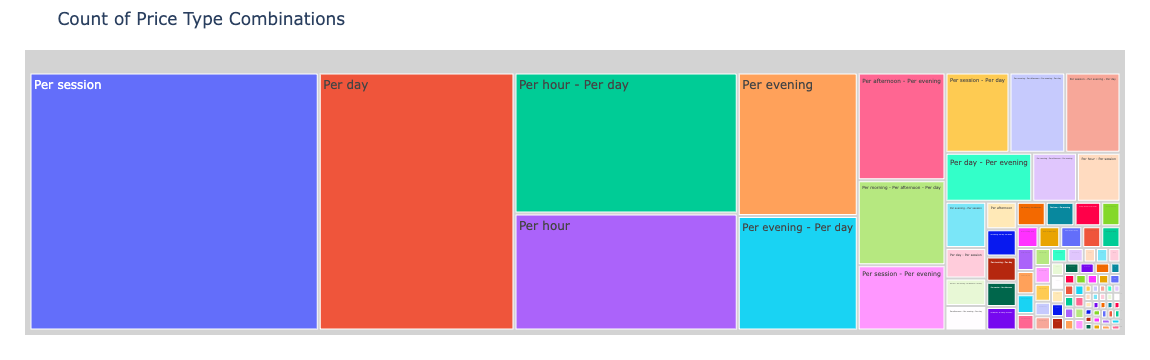

In [342]:
fig = px.treemap(price_period_desc_counts, path=['index'], values='price_period_desc', 
                 title = 'Count of Price Type Combinations')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

- All combinations of price type and pricing period
- This time, its noit contriobution per space, but simply contribution e.g. how many separate spaces would contribute to each combination of price type and pricing period

In [346]:
# Remove weekdays and get all combinations of price type  and pricing period for all spaces
price_types_and_periods = prices.drop_duplicates(['space_url', 'price_type', 'price_period_desc'])
# Group by price type and period i.e. count of spaces within each combination of price type and period  
price_types_and_periods = price_types_and_periods.groupby(['price_type', 'price_period_desc'], 
                                                      as_index = False)
# Concatenates price types together into single string per space url
price_types_and_periods = price_types_and_periods['space_url'].agg('count')
price_types_and_periods

,price_type,pricing_period,space_url
0,hire fee,Per afternoon,214
1,hire fee,Per day,1553
2,hire fee,Per evening,409
3,hire fee,Per morning,234
4,hire fee,Per session,412
5,hire fee + min. spend,Per afternoon,25
6,hire fee + min. spend,Per day,55
7,hire fee + min. spend,Per evening,83
8,hire fee + min. spend,Per morning,13
9,hire fee + min. spend,Per session,108


**price_types_per_space** now contains 1 row per event space and in the **price_type** column it has combined all price types used by that event space into a single string e.g. if a venue used 'hire fee' and 'min. spend' then it would have 'hire fee - min. spend' in the **price_type** column. We will now perform a value count on this to get the relative number of event spaces using different combinations of price types. We will plot this as well. 

/opt/homebrew/Caskroom/miniforge/base/envs/venue-scrape2/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/homebrew/Caskroom/miniforge/base/envs/venue-scrape2/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



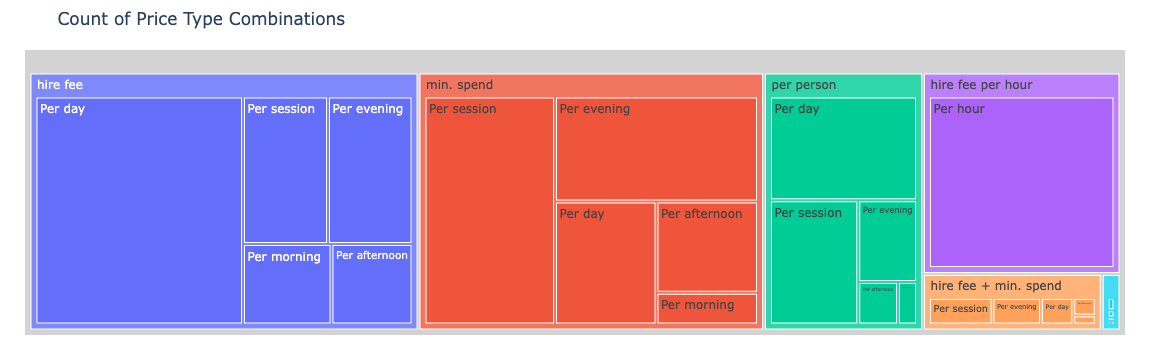

In [347]:
fig = px.treemap(price_types_and_periods, path=['price_type', 'price_period_desc'], values='space_url', 
                 title = 'Count of Price Type Combinations')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## Next step: 
- Move this to start, add comments and text
- repeat this analysis but include time period description (need naming convention for this!!!)
  - remove dupes on url, price type, price period and price text  
  - Split time description into variant and invariant
  - Create above plot with 3 levels...or 4...basically price type then time period then varies or doesnt vary and raw numbers per time....hmmm maybe think more on this...do we group when similar start timke? Or time period? Or what? Maybe simpler way to quantify like simply calculate number of prices data that actually do this and convert to single chart showing breakdowns...yes variant and invariant and in invariant maybe times....to get splits...maybe...or simple chart with bars...hmmm...

## Big Questions: 
Can you combine per session and per evening? How different our these prices? how does time of day affect prices? 
- within said price type, what is the spread of prices for different price periods e.g. per session vs per evening -> Median, mean, normalised histograms...is there a hint of similarity?
- Again, within the price types, are they descriptively similar e.g. similar length of time? Similar start or end times?
- For both above, how to deal with time of day differences...last time I just ignored them...maybe need to figure that out next i.e. quantify how much variation there is, how many counts would be available, can we do meaningful regression or should we aggregate?  

### Investigate price_period -> implications for price type? Implications for weekly data? hmmm....implications for regression! 
some ideas: 
- probably start with some simple remove duplicates and value count the time periods...
- combine price period and price type together as combined 'price type + period'?
- how are remove duplicates affected? Is old analysis still valid? 
- How to deal with price type + period...probably need to regress comparable ones otherwise a hire fee for half day probably not legit...


In [252]:
# group prices by price type and space url, this time we include weekdays
# as well e.g. each space and price type will occur up to 7
# times (once for each weekday)
price_types_per_space = prices.groupby(['space_url', 'price_type', 'price_period_desc'])

weekly_price_variation = price_types_per_space.agg(
    num_prices = ('total_price', pd.Series.nunique))#.reset_index()

weekly_price_variation

num_prices
space_url                                          price_type            pricing_period            
https://www.tagvenue.com/rooms/barnes/7039/the-... per person            Per session              1
https://www.tagvenue.com/rooms/barnes/7040/the-... per person            Per session              1
https://www.tagvenue.com/rooms/barnes/7041/the-... per person            Per session              1
https://www.tagvenue.com/rooms/barnet/8642/go-a... per person            Per session              1
https://www.tagvenue.com/rooms/bayswater/3062/q... hire fee + min. spend Per session              3
...                                                                                             ...
https://www.tagvenue.com/rooms/twickenham/7966/... hire fee              Per day                  1
                                                                         Per morning              1
https://www.tagvenue.com/rooms/walton-on-thames... per person            Per session              1
https://www.tagvenue.com/rooms/watford/7846/wrf... hire fee              Per day                  1
https://www.tagvenue.com/rooms/watford/7847/wrf... hire fee per hour     Per hour                 1

[7914 rows x 1 columns]

In [253]:
weekly_price_variation.num_prices.value_counts()

1     6100
2     1108
3      310
4      167
5      119
6       55
7       23
8       16
10       8
9        8
Name: num_prices, dtype: int64

In [223]:
no_week_variation = weekly_price_variation[weekly_price_variation.num_prices == 1]
num_no_week_variation = no_week_variation.price_type.count()
total = weekly_price_variation.shape[0]
num_week_variation = total - num_no_week_variation

print(f"{num_no_week_variation} out of {total} spaces do not vary on different weekdays. -> {(num_no_week_variation / total):.0%}")
print(f"{num_week_variation} out of {total} spaces vary on different weekdays.")

3807 out of 6139 spaces do not vary on different weekdays. -> 62%
2332 out of 6139 spaces vary on different weekdays.


In [197]:
no_week_variation = weekly_price_variation[weekly_price_variation.price_variation == 1]
num_no_week_variation = no_week_variation.variation.count()
total = weekly_price_variation.shape[0]
num_week_variation = total - num_no_week_variation

print(f"{num_no_week_variation} out of {total} spaces do not vary on different weekdays. -> {(num_no_week_variation / total):.0%}")
print(f"{num_week_variation} out of {total} spaces vary on different weekdays.")

4575 out of 6139 spaces do not vary on different weekdays. -> 75%
1564 out of 6139 spaces vary on different weekdays.


In [ ]:
weekly_price_variation

In [242]:
def variation(data):
    return np.max(data) - np.min(data)

weekday_pivot = pd.pivot_table(prices, index=['space_url', 'price_type'],
                    columns=['day_of_week'], values = ['total_price'])

weekday_pivot[('total_price','variation')] = weekday_pivot.max(axis = 1) - weekday_pivot.min(axis = 1)
# Remove multi index -> this makes it easier to plot
#weekday_pivot = weekday_pivot.reset_index()
weekday_pivot = weekday_pivot.droplevel(axis = 1, level=0)
# Cahnge level to 1 above!!! and see if renaming can be ingnored!!!
# Rename columns lost when removing multindex
cols=pd.Series(weekday_pivot.columns)
#cols[0] = 'space_url'
#cols[1] = 'price_type'
weekday_pivot.columns = cols

weekday_pivot.head(10)

day_of_week                                                               Friday  ...  variation
space_url                                          price_type                     ...           
https://www.tagvenue.com/rooms/barnes/7039/the-... per person               20.0  ...        0.0
https://www.tagvenue.com/rooms/barnes/7040/the-... per person               20.0  ...        0.0
https://www.tagvenue.com/rooms/barnes/7041/the-... per person               20.0  ...        0.0
https://www.tagvenue.com/rooms/barnet/8642/go-a... per person               33.0  ...        0.0
https://www.tagvenue.com/rooms/bayswater/3062/q... hire fee + min. spend  2000.0  ...      500.0
https://www.tagvenue.com/rooms/bayswater/3064/q... min. spend             2500.0  ...        0.0
https://www.tagvenue.com/rooms/brentford/17965/... hire fee                100.0  ...        0.0
                                                   hire fee per hour        25.0  ...        0.0
https://www.tagvenue.com/rooms/brentford/17966/... hire fee                175.0  ...        0.0
                                                   hire fee per hour        30.0  ...        0.0

[10 rows x 8 columns]

In [235]:
weekday_pivot.merge(weekly_price_variation[['space_url', 'num_prices']], on = 'space_url', how = 'left')

,space_url,price_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,variation,num_prices
0,https://www.tagvenue.com/rooms/barnes/7039/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
1,https://www.tagvenue.com/rooms/barnes/7040/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
2,https://www.tagvenue.com/rooms/barnes/7041/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
3,https://www.tagvenue.com/rooms/barnet/8642/go-...,per person,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,0.0,1
4,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,2000.000000,1750.000000,2250.000000,2250.000000,2000.000000,1750.000000,1750.000000,500.0,3
...,...,...,...,...,...,...,...,...,...,...,...
9098,https://www.tagvenue.com/rooms/twickenham/7965...,hire fee,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,0.0,2
9099,https://www.tagvenue.com/rooms/twickenham/7966...,hire fee,185.333333,185.333333,185.333333,185.333333,185.333333,185.333333,185.333333,0.0,2
9100,https://www.tagvenue.com/rooms/walton-on-thame...,per person,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,0.0,1
9101,https://www.tagvenue.com/rooms/watford/7846/wr...,hire fee,300.000000,300.000000,NaN,NaN,300.000000,300.000000,300.000000,0.0,1


In [244]:
weekday_pivot.join(weekly_price_variation).reset_index()

,space_url,price_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,variation,num_prices
0,https://www.tagvenue.com/rooms/barnes/7039/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
1,https://www.tagvenue.com/rooms/barnes/7040/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
2,https://www.tagvenue.com/rooms/barnes/7041/the...,per person,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,1
3,https://www.tagvenue.com/rooms/barnet/8642/go-...,per person,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,0.0,1
4,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,2000.000000,1750.000000,2250.000000,2250.000000,2000.000000,1750.000000,1750.000000,500.0,3
...,...,...,...,...,...,...,...,...,...,...,...
6134,https://www.tagvenue.com/rooms/twickenham/7965...,hire fee,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,0.0,2
6135,https://www.tagvenue.com/rooms/twickenham/7966...,hire fee,185.333333,185.333333,185.333333,185.333333,185.333333,185.333333,185.333333,0.0,2
6136,https://www.tagvenue.com/rooms/walton-on-thame...,per person,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,0.0,1
6137,https://www.tagvenue.com/rooms/watford/7846/wr...,hire fee,300.000000,300.000000,NaN,NaN,300.000000,300.000000,300.000000,0.0,1


In [249]:
weekday_pivot.iloc[6135]#.nunique()

day_of_week
Friday       185.333333
Monday       185.333333
Saturday     185.333333
Sunday       185.333333
Thursday     185.333333
Tuesday      185.333333
Wednesday    185.333333
variation      0.000000
Name: (https://www.tagvenue.com/rooms/twickenham/7966/st-marys-university-twickenham/shannon-2, hire fee), dtype: float64

In [251]:
test = prices[prices.space_url == 'https://www.tagvenue.com/rooms/twickenham/7966/st-marys-university-twickenham/shannon-2']

test.groupby(['space_url', 'price_type']).agg(
    num_prices = ('total_price', pd.Series.nunique))#.reset_index()

,,num_prices
space_url,price_type,
https://www.tagvenue.com/rooms/twickenham/7966/st-marys-university-twickenham/shannon-2,hire fee,2


Below we breakdown the count of no variation for different price_types:

In [198]:
no_variation_price_type_counts = no_week_variation.price_type.value_counts()
total_price_type_counts = weekday_pivot.price_type.value_counts()


perc_no_variation_per_price_type = no_variation_price_type_counts / total_price_type_counts *100

perc_no_variation_per_price_type

hire fee                 84.205180
min. spend               51.672060
hire fee per hour        83.810376
per person               92.116183
hire fee + min. spend    53.333333
hire fee + per person    91.666667
Name: price_type, dtype: float64

**Observations:**
- hire fee has large majority with no price variation per weekday. 
- min spend has at least 50% with variation per weekday! May be worth including or calculating...separate models? Or add simple average? 

In [199]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [200]:
week_variation = weekday_pivot[weekday_pivot.variation > 0]

# Unpivot weekday prices to make plotting easier 
week_variation = week_variation.melt(id_vars = ['space_url', 'price_type'], 
                    value_vars = weekdays, value_name = 'total_price')

week_variation = week_variation.dropna(subset = ['total_price'])
week_variation

,space_url,price_type,day_of_week,total_price
0,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Monday,1750.0
1,https://www.tagvenue.com/rooms/brentford/1828/...,hire fee,Monday,280.0
2,https://www.tagvenue.com/rooms/camden/1087/sha...,per person,Monday,50.0
3,https://www.tagvenue.com/rooms/camden/1088/sha...,per person,Monday,50.0
4,https://www.tagvenue.com/rooms/camden/3047/sha...,per person,Monday,50.0
...,...,...,...,...
10942,https://www.tagvenue.com/rooms/south-woodford/...,min. spend,Sunday,1000.0
10943,https://www.tagvenue.com/rooms/surrey/1247/rav...,hire fee per hour,Sunday,350.0
10944,https://www.tagvenue.com/rooms/surrey/1248/rav...,hire fee per hour,Sunday,250.0
10945,https://www.tagvenue.com/rooms/twickenham/1072...,per person,Sunday,70.0


In [201]:
price_type_order.tolist()

[32.07362762664929,
 30.200358364554486,
 18.21143508714774,
 15.702883205733833,
 3.4207525655644244,
 0.39094315035021987]

In [202]:
price_type_order = price_types_per_space['price_type'].value_counts().index.tolist()
fig = px.box(week_variation, y="total_price", facet_row="price_type", color="day_of_week", 
             height = 1200, points = 'all', category_orders = {'price_type':price_type_order})


fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

# Need to re-order weekdays to make it more sensible! e.g. Mon to Sunday! 
# Need to re-order facet row to be largest to smallest...e.g. via price_types_per_space['price_type'].value_counts()

ValueError: Vertical spacing cannot be greater than (1 / (rows - 1)) = 0.027778.
The resulting plot would have 37 rows (rows=37).
Use the facet_row_spacing argument to adjust this spacing.

In [203]:
fig = px.histogram(week_variation, x="total_price", facet_row="price_type", 
                   facet_col="day_of_week", color = 'day_of_week', height = 1200, 
                   category_orders = {'price_type':price_type_order})
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_xaxes(matches=None, showticklabels=True)
fig.show()


ValueError: Vertical spacing cannot be greater than (1 / (rows - 1)) = 0.027778.
The resulting plot would have 37 rows (rows=37).
Use the facet_row_spacing argument to adjust this spacing.

In [ ]:
no_week_variation.price_type.value_counts()

In [ ]:
import plotly.express as px

fig = px.histogram(weekday_pivot, x = 'variation')
fig.show()

Improvements: 
- Number of price types per venue i.e. typical and is there one thats usually available? Whats the crossover? 
- Get sense of weekly relevance i.e. pricing usually same every weekday? Or different on certain days?

Ideas: 
- Repeat same analysis as above but include weekdays i.e. use index of url + weekday and if the chart is similar shape to above (similar %) then weekdays probably dont change pricing fit? Or do one per week day and compare? Yes that sounds better...
- Is price type typically uniform for all spaces within a venue or varies per room? 
- price variation per week - Do pivot chart with space url and price type as index and columns as the weekdays! then can easily do stand deviation to see which ones don't vary! 


- For weekday differences, perhaps plot bar plots or historams, split by pruce type i.e. new chart poer price type, done per weekday (colored by weekday) and see if they all look similar? 
- or for weekdays -> Do groupby standard deviation of total price across weekdays per space and price type -> std is 0 if prices dont vary accross weekdays. Can get average? Or simply do binary check of how many actually vary at all? Per perice type? Thats a good start! yep, start with that, how many even vary...then go from there :) e.g. how much variation? What days in particualr (maybe distribution graphs or median calculations become useful :) 


Next steps: 
- Weekday analysis (pivot table) 
- investigate Hire Fee and Hire Fee per Hour -> relationship? in breakdown, they are often combined and so can directly calculate...
- Can per person be sensibly converted to min spend or hire fee? How / why? hmmm....? 
- Conversion analysis -> Use Crossover Analysis of price types, is there a sensible correlation? Is it worth doing a simple OLS model to figure out conversion? 
- Converting hire fee to min spend -> Could regress each separately then plot their models against one another i.e. y against Y perhaps for the training data i.e. using same training data and see if there is some obvious function that might link them...could generate training data randomly generated and picked within expected ranges...and then y vs y and see if anything clear appears...that could show an equation to combine...
- Or test each on the others training data...yeah basically just predict whole dataset with both and see if they have obvious relationship (plot y agaisnt y) 
- Discuss finding and ideas with Tara
- Consider options and how you could use final models to prove if conversion makes sense...
- Post question on facebook / forum :) 

Options: 
- Simplest -> Hire Fee only, Min Spend Only models -> maybe per person...but do we even need that? 
- Then after making individual models, see if I can prove via models that there is a better combination e.g.: 
  - The regression models have clear linear regression conversion caluclation e.g. divide by x and multiply by y
  - the combined regression model (using some conversion calculation) is better than without (is that legit...or confused?) 
  - See stuff below e.g. Domain knowledge etc. and what Tara and luke want it for...


- Single model for all price types with dodgy conversions 
- use 'price_type' as categorical variable...but will it be good enough to change regression? In tree model maybe...in regression probably not with any encoding...but maybe I should review total cost per price_type and see if I can see a sensible conversion?  
- Something in between? 
- For all of the above...how to confirm your suspicions? 
  - Domain knowledge? 
  - Or can you make separate and combined models and test which is less error?
  - Do you look and see if the models are similar in shape and that tells you how you can convert from one to another (e.g. if Y = 2x + 4 snd Y' = 4x + 4 then clearly you double y yo get y'....but I want to calculate just using minimum spend from number of people...maybe I model both and see if there is an abvious way to make omne the other....hmmmm....
  - Can you optimise the formula for converting from one to another e.g. after making the models? 
  - Can you use overlaps between pricing types to calculate / test conversion approach?   
- Weekdays or no? Add average value for weekends? 

Awesome stuff: 

- next steps -> do count per weekday / price type split for variation -> do we have enough observations for model to be worthwhile? 
- Anova on group by and maybe other specific differences in median (I read an article recently on this exact use case) -> calculate statiatical difference 
- Perhaps STD as well to measure how much it varies around mean / median -> a lot means a worse addition of an % fraction...
- big question -> do we have enough observations for separate model? If yes, probably need full model and no variation and variation all separate because combining makes no sense since the no weekly variation stuff won't be easily testable except on the varying data! i.e. for the non-varying data it will surely make the predictions worse or at least no better because there will be a fight between it never varies and it sometimes varies and that waters down variation...

- If we chose to ignore variation, what value do we take from across the week? Median? Mean? Min? Max? Or could regress min and max as separate data? The ones that are not varying, are they average prices or minimum prices? Or max prices? Is there a way to tell? Perhaps take non varying aside, regress it and test on different weekly variation aggregations e.g. Max, Min, Average...
- Separate models for varying and non varying? Hmmmm....
- If we want to add % to predicted answer, could take min to regress then we are adding % on top of this -> if you took this approach then you could test if the accuracy is improved for the data that varies! and could then compare this to regressing all week day? Maybe consider regressing min + % increase and see how that compares. 

Key options: 
- Regress No variation and Variation separately and test each on separate test data -> Pros, makes sense, cons, maybe poor observation numbers 
- Regress on no variation alone and then test it on varying data using different aggregations (max, min, average etc.) and see which predicts it best...that's probably the most representative aggregation
- Do above and add % increase and test on varying data only using different weekday cuts and see if better with % increase or with separate models above...
- Finally, is there a sensible way to stack the non varying and varying data -> The biggest problem I see is no way to properly test because it will better predict varying on varying data and not varying on not varying data so a lower test score doesn't mean worse at predicting variation necessarily...does that make sense 


- Latest observations: 
  - Each price type appears to behave differently during week e.g. hire fee very different to min spend -> probably regress separately 
  - Probably should do model per weekday - flat % difference no good because variation is very large approx 100% and seems different for each type of price...so probably they all behave differently and are catered to different people...
  - worth calling out the specific differences...
  - Probably not gonna use some combined model...I think separate makes more sense now...maybe consider how one price could map to others still...maybe...
- Do ANOVA as minimum to see if significant difference between means...then maybe one by one if you need to...if not significant then not really legit
- Do geo plot of lat and long for different price types...still good coverage of london? 
- Consider implications e.g. how to treat different days? Maybe I create separate models per weekday? hmmmmmmm what about nans? Models per weekday would propely calcualte relationships of weekday bonus and difeereny areas (i.e. relationship with other variables) so probably better than not...is there enough data? what about the huge amounts of non varying data? Won't that impact things?
- Consider the non variation counts for different price types e.g. hire fee is generally flat but 50% of minimum spend varies...
**possible options**:
  - Ignore weekdays entirely
  - Add average change to price based purely on weekday (dosnt capture bugger incereases in more popular areas...although that may not happen...% increase! 
  - Perform separate model for each week day...but concerned about impact of most not varying...
  - Do combo models, one model of all / just non varying and another of just varying and combine together...would need to google but could be cool... 

**Observations:**
- Mean is approx same for Monday - Wednesday and is higher on from Thursday to Sunday -> Potentially combine into categorical variable of day of week...but what about nans? And what about repeated rows...isnt that a problem? hmmmmm...not sure, need to consider. 
- Median highlights only Sat and Sun in particualar. 

In [204]:
week_variation

,space_url,price_type,day_of_week,total_price
0,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Monday,1750.0
1,https://www.tagvenue.com/rooms/brentford/1828/...,hire fee,Monday,280.0
2,https://www.tagvenue.com/rooms/camden/1087/sha...,per person,Monday,50.0
3,https://www.tagvenue.com/rooms/camden/1088/sha...,per person,Monday,50.0
4,https://www.tagvenue.com/rooms/camden/3047/sha...,per person,Monday,50.0
...,...,...,...,...
10942,https://www.tagvenue.com/rooms/south-woodford/...,min. spend,Sunday,1000.0
10943,https://www.tagvenue.com/rooms/surrey/1247/rav...,hire fee per hour,Sunday,350.0
10944,https://www.tagvenue.com/rooms/surrey/1248/rav...,hire fee per hour,Sunday,250.0
10945,https://www.tagvenue.com/rooms/twickenham/1072...,per person,Sunday,70.0


In [205]:
week_variation['perc_change'] = week_variation.groupby(['space_url', 'price_type'])['total_price'].transform(lambda x: (x - min(x))/ min(x) * 100)

In [206]:
week_variation.sort_values(['space_url', 'price_type','day_of_week']).head(100)

,space_url,price_type,day_of_week,total_price,perc_change
6256,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Friday,2000.0,14.285714
0,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Monday,1750.0,0.000000
7820,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Saturday,2250.0,28.571429
9384,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Sunday,2250.0,28.571429
4692,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Thursday,2000.0,14.285714
1564,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Tuesday,1750.0,0.000000
3128,https://www.tagvenue.com/rooms/bayswater/3062/...,hire fee + min. spend,Wednesday,1750.0,0.000000
6257,https://www.tagvenue.com/rooms/brentford/1828/...,hire fee,Friday,350.0,25.000000
1,https://www.tagvenue.com/rooms/brentford/1828/...,hire fee,Monday,280.0,0.000000
7821,https://www.tagvenue.com/rooms/brentford/1828/...,hire fee,Saturday,350.0,25.000000


In [207]:
fig = px.box(week_variation, y="perc_change", facet_row="price_type", color="day_of_week", 
             height = 1200, points = 'all', category_orders = {'price_type':price_type_order})


fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

ValueError: Vertical spacing cannot be greater than (1 / (rows - 1)) = 0.027778.
The resulting plot would have 37 rows (rows=37).
Use the facet_row_spacing argument to adjust this spacing.

In [ ]:
fig = px.histogram(week_variation, x="perc_change", facet_row="price_type", 
                   facet_col="day_of_week", color = 'day_of_week', height = 1200, 
                   category_orders = {'price_type':price_type_order})
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_layout(xaxis_range=[0,200])
fig.show()

# Consider Adding zoom or removing silly percentages....
# Consider Overlaying chart with zeros info...

In [ ]:
week_variation

In [ ]:
week_variation['day_of_week'] = pd.Categorical(week_variation.day_of_week, 
                      categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                      ordered=True)

week_variation.sort_values('day_of_week', inplace = True)

In [ ]:
prices_metrics.columns

In [ ]:
prices_metrics = week_variation.groupby(['price_type', 'day_of_week'])['total_price','perc_change'].agg(['mean', 'median'])
prices_metrics = prices_metrics.reset_index()
#Drop multi index to make plotting easier
prices_metrics.columns = ["_".join(col_name).rstrip('_') for col_name in prices_metrics.columns]

prices_metrics.head()

In [ ]:
prices_metrics = prices_metrics.melt(id_vars = ['price_type','day_of_week'], value_vars = ['total_price_mean', 'total_price_median', 'perc_change_mean', 'perc_change_median'])

In [ ]:
prices_metrics

In [ ]:
fig = px.bar(prices_metrics, barmode='group', height = 1400, 
             facet_row = 'price_type', facet_col = 'variable', 
             color = 'day_of_week' ,y = 'value', 
             category_orders = {'price_type':price_type_order})

fig.update_xaxes(matches=None, showticklabels=True)
fig.update_yaxes(matches=None, showticklabels=True)


fig.show()

In [ ]:
300/20

## reference

In [ ]:
week_variation.groupby(['price_type', 'day_of_week'])['total_price'].agg('count')

In [ ]:
prices['unique'] = prices.groupby(['space_url', 'price_type'])['total_price'].transform(pd.Series.nunique)

In [ ]:
prices.drop_duplicates(['space_url', 'price_type'])[prices.unique == 1][['price_type', 'unique']].count()

In [ ]:
price_types_per_space['price_type_'] = 1

In [ ]:
table = pd.pivot_table(price_types_per_venue, index=['venue_url'],
                    columns=['price_type'], values = ['v'], margins = True, aggfunc=np.sum)
table

In [ ]:
table.columns

In [ ]:
table[ ('v', 'All')].value_counts()

In [ ]:
table[('v', 'All')].values[0:-1]

In [ ]:
table.columns

In [ ]:
2560/1741

- repeat analysis per space
- run week analysis -> could do something similar to above? or not? How stable are prices and price_types?  

In [ ]:
table

In [ ]:
# Total spaces
venues.shape

In [ ]:
# Price options total
price_types_per_venue.shape

In [ ]:
# Unique Venues
venues.venue_url.drop_duplicates().count()

In [ ]:
2560 - 1739

## Options: 
- Regress min.spend and hire fee etc. separately...
- Somehow convert...

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns
matrix = test.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()


In [ ]:
import pandas as pd
data = [[5,0,1,0,0,1], [6,1,0,1,0,0], [3,1,0,0,1,0], [2,0,1,0,0,1], [4,1,0,1,0,0], [1,1,0,0,1,0], [7,0,1,0,0,1], [9,1,0,1,0,0], [2,1,0,0,1,0], [7,0,1,0,0,1], [6,1,0,1,0,0], [2,1,0,0,1,0]]

test = pd.DataFrame(data, columns = ['y','a','b','c','d','e'])

In [ ]:
y = test['y']
x = test.loc[:,'c':'d']

In [ ]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(x,y)


In [ ]:
ols.coef_

In [ ]:
ols.intercept_

In [ ]:
ols.score(x,y)

In [ ]:
ols.coef_

In [ ]:
ols.intercept_

In [ ]:
ols.score(x,y)

In [ ]:
ols.predict(np.array([1,0,1,0,0]).reshape(1,-1))

In [ ]:
ols.predict(np.array([1,0]).reshape(1,-1))

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x,y)

In [ ]:
clf.coef_

In [ ]:
clf.intercept_

In [ ]:
clf.score(x,y)

In [ ]:
from sklearn.linear_model import Ridge



In [ ]:
y = test['y']
x = test.loc[:,'a':'d']

In [ ]:
from sklearn.linear_model import LinearRegression
rid = Ridge(alpha = 1)
rid.fit(x,y)


In [ ]:
rid.coef_

In [ ]:
rid.intercept_

In [ ]:
rid.score(x,y)

In [ ]:
y = test['y']
x = test.loc[:,'a':'c']

In [ ]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(x,y)


In [ ]:
ols.coef_

In [ ]:
ols.intercept_

In [ ]:
ols.score(x,y)

In [ ]:
venues.info()

Interpretation: 

remianing columns questions: 
- What does nan mean? Should I replace it? 
- How many True / False / nan? Even worth keeping? 
- combine with anything else? 

- for parking - combine 3 together! 

In [ ]:
venues.head()

In [ ]:
venues[venues['Halal menu'].isnull()].space_url

In [ ]:
venues.info(verbose = True)

Cleaning to do: 
- compare difference in null values between the 2 standing_max columns 
- combine parking into 1 column
- combine alcohol licenses (one outside the bunch) to a single column and check adds to 1 i.e. OHE / mutually exclusive and got all (there shouldnt be a null value...) 
- test adds up to 1 on mutually exclusive / OHE type ones 

### Hire Fee Per Hour to Hire Fee Conversion ->>> FLAWED!!! need to deal with pricing period stuff as well!!! Move to ater they are combined!!!
We will now investigate whether we can derive an equation to convert hire fee per hour to hire fee. First we will select all the event spaces that were categorised as 'hire fee per hour - hire fee' and call these 'hire_fee_overlap'. 

In [179]:
hire_fee_overlap_urls = price_types_per_space.space_url[
    price_types_per_space.price_type == 'hire fee per hour - hire fee']

hire_fee_overlap = prices[prices.space_url.isin(hire_fee_overlap_urls)]

In [180]:
hire_fee_overlap

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,time_period,total_price,price_type,rent_price_split,min_spend_split,per_person_split
194,https://www.tagvenue.com/rooms/london/29060/be...,https://www.tagvenue.com/venues/london/13904/b...,belsize park,luxury apartment,51.545967,-0.174705,Monday,Per hour,6.0,18.0,12.0,98.0,hire fee per hour,NaN,NaN,NaN
195,https://www.tagvenue.com/rooms/london/29060/be...,https://www.tagvenue.com/venues/london/13904/b...,belsize park,luxury apartment,51.545967,-0.174705,Monday,Per day,6.0,18.0,12.0,850.0,hire fee,NaN,NaN,NaN
196,https://www.tagvenue.com/rooms/london/29060/be...,https://www.tagvenue.com/venues/london/13904/b...,belsize park,luxury apartment,51.545967,-0.174705,Tuesday,Per hour,6.0,18.5,12.5,95.0,hire fee per hour,NaN,NaN,NaN
197,https://www.tagvenue.com/rooms/london/29060/be...,https://www.tagvenue.com/venues/london/13904/b...,belsize park,luxury apartment,51.545967,-0.174705,Tuesday,Per day,6.0,18.5,12.5,850.0,hire fee,NaN,NaN,NaN
198,https://www.tagvenue.com/rooms/london/29060/be...,https://www.tagvenue.com/venues/london/13904/b...,belsize park,luxury apartment,51.545967,-0.174705,Wednesday,Per hour,6.0,6.5,0.5,95.0,hire fee per hour,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51655,https://www.tagvenue.com/rooms/london/21604/ar...,https://www.tagvenue.com/venues/london/8850/ar...,arboretum,the hub on the square,51.509611,-0.127755,Thursday,Per session,8.0,17.0,9.0,1000.0,hire fee,NaN,NaN,NaN
51656,https://www.tagvenue.com/rooms/london/21604/ar...,https://www.tagvenue.com/venues/london/8850/ar...,arboretum,the hub on the square,51.509611,-0.127755,Thursday,Per session,17.0,0.0,7.0,1000.0,hire fee,NaN,NaN,NaN
51657,https://www.tagvenue.com/rooms/london/21604/ar...,https://www.tagvenue.com/venues/london/8850/ar...,arboretum,the hub on the square,51.509611,-0.127755,Friday,Per hour,7.0,0.0,17.0,200.0,hire fee per hour,NaN,NaN,NaN
51658,https://www.tagvenue.com/rooms/london/21604/ar...,https://www.tagvenue.com/venues/london/8850/ar...,arboretum,the hub on the square,51.509611,-0.127755,Friday,Per session,8.0,17.0,9.0,1000.0,hire fee,NaN,NaN,NaN


Next, we will pivot out the data for plotting. We want to plot 'hire fee' against 'hire fee per hour', so we need these in separate columns. We will include the time_period as well because we want to test whether multiplying the hire fee per hour by the time period gets us the hire fee. 

In [181]:
plotting_table = hire_fee_overlap.pivot_table(index = ['space_url', 
                                                       'day_of_week', 
                                                       'time_period'],
                                              columns = ['price_type'], 
                                              values = 'total_price')
plotting_table

price_type                                                                  hire fee  hire fee per hour
space_url                                          day_of_week time_period                             
https://www.tagvenue.com/rooms/brentford/17965/... Friday      9.0             100.0               25.0
                                                   Monday      9.0             100.0               25.0
                                                   Thursday    9.0             100.0               25.0
                                                   Tuesday     9.0             100.0               25.0
                                                   Wednesday   9.0             100.0               25.0
...                                                                              ...                ...
https://www.tagvenue.com/rooms/twickenham/7910/... Thursday    8.0             450.0               84.0
                                                   Tuesday     4.0             297.0                NaN
                                                               8.0             450.0               84.0
                                                   Wednesday   4.0             297.0                NaN
                                                               8.0             450.0               84.0

[4698 rows x 2 columns]

In [182]:
# make venue_url and day_of_week usable as columns
plotting_table = plotting_table.reset_index()
# Calculate new column that multiplies hire fee per hour by time_period
plotting_table['per hour x time_period'] = (plotting_table.time_period 
                                            * plotting_table['hire fee per hour']
                                        )

Finally, we plot our data in 2 separate plots, splitting the data by day_of_week: 

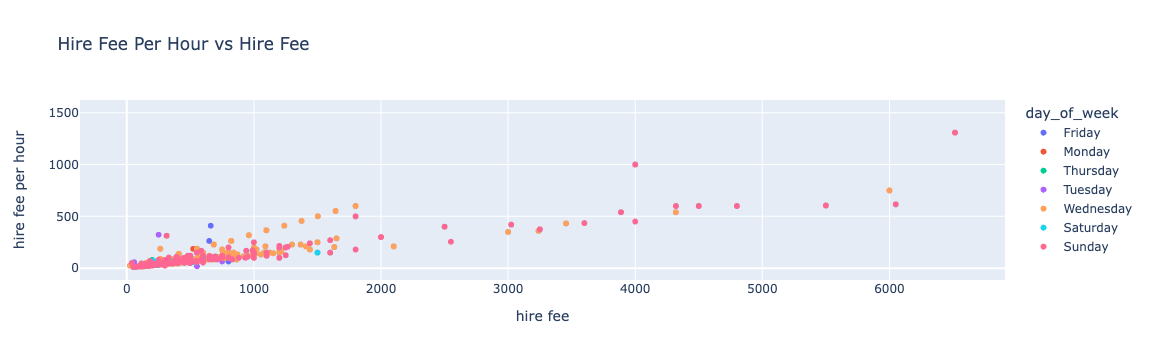

In [183]:
fig = px.scatter(plotting_table, x="hire fee", y="hire fee per hour", 
                 color = 'day_of_week', title = 'Hire Fee Per Hour vs Hire Fee')
fig.show()

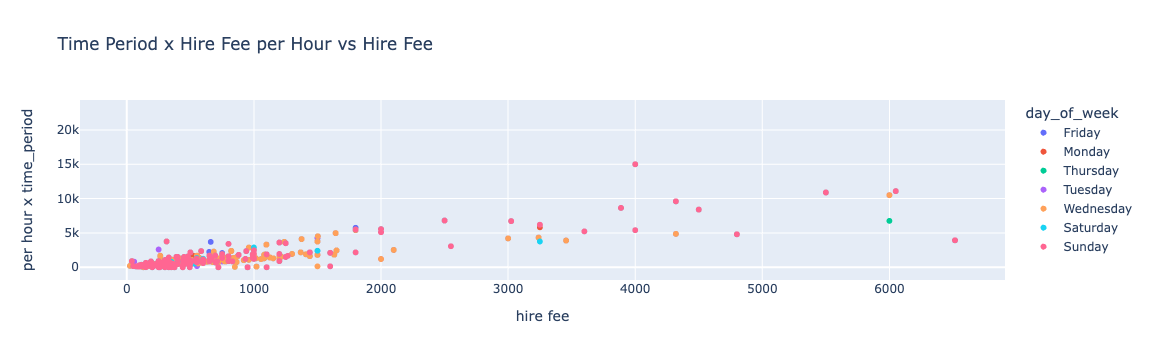

In [184]:
fig = px.scatter(plotting_table, x="hire fee", y="per hour x time_period", 
                 color = 'day_of_week', 
                 title = 'Time Period x Hire Fee per Hour vs Hire Fee')
fig.show()

**Observations:**
- The above charts indicate an approximately linear relationship between both Hire fee per hour and Hire Fee. It has a funnel shape i.e. the spread increases for larger hire fee values. 
- Multiplying the Hire Fee per hour by time_period did not really improve the linear relationship
- The relationship between hire fee and hire fee per hour is clearly more complicated than a simple conversion equation such as multiplying by time_period. It probably varies based on location and other factors. We don't think it would be sensible to try and regress this relationship to convert hire fee per hour to hire fee because it would incur errors in our target value which will likely make the model worse. We will abandon any attempt to convert these variables.

### Per Person to Hire Fee Conversion
We will now repeat the same analysis on the spaces which use both 'per person' and 'hire fee' to see iof we can derive an equation to convert between these variables. 

In [185]:
hire_per_person_overlap_urls = price_types_per_space.space_url[
    price_types_per_space.price_type == 'hire fee - per person']

hire_per_person_overlap = prices[prices.space_url.isin(hire_per_person_overlap_urls)]

In [186]:
hire_per_person_overlap

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,time_period,total_price,price_type,rent_price_split,min_spend_split,per_person_split
7,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,Monday,Per day,9.0,17.0,8.0,1740.0,hire fee,NaN,NaN,NaN
8,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,Monday,Per day,9.0,17.0,8.0,67.0,per person,NaN,NaN,NaN
9,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,Tuesday,Per day,9.0,17.0,8.0,1740.0,hire fee,NaN,NaN,NaN
10,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,Tuesday,Per day,9.0,17.0,8.0,67.0,per person,NaN,NaN,NaN
11,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,Wednesday,Per day,9.0,17.0,8.0,1740.0,hire fee,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50832,https://www.tagvenue.com/rooms/london/14240/st...,https://www.tagvenue.com/venues/london/6377/st...,st. pancras meetings & events,games room,51.529178,-0.123285,Saturday,Per session,9.0,18.0,9.0,95.0,per person,NaN,NaN,NaN
50833,https://www.tagvenue.com/rooms/london/14240/st...,https://www.tagvenue.com/venues/london/6377/st...,st. pancras meetings & events,games room,51.529178,-0.123285,Sunday,Per morning,9.0,13.0,4.0,420.0,hire fee,NaN,NaN,NaN
50834,https://www.tagvenue.com/rooms/london/14240/st...,https://www.tagvenue.com/venues/london/6377/st...,st. pancras meetings & events,games room,51.529178,-0.123285,Sunday,Per afternoon,14.0,18.0,4.0,420.0,hire fee,NaN,NaN,NaN
50835,https://www.tagvenue.com/rooms/london/14240/st...,https://www.tagvenue.com/venues/london/6377/st...,st. pancras meetings & events,games room,51.529178,-0.123285,Sunday,Per day,9.0,18.0,9.0,636.0,hire fee,NaN,NaN,NaN


Next, we will pivot out the data for plotting. We want to plot 'hire fee' against 'per person', so we need these in separate columns.

In [187]:
plotting_table = hire_per_person_overlap.pivot_table(index = ['space_url', 
                                                       'day_of_week'],
                                              columns = ['price_type'], 
                                              values = 'total_price')
plotting_table

price_type                                                      hire fee  per person
space_url                                          day_of_week                      
https://www.tagvenue.com/rooms/london/10101/rad... Friday          250.0        52.5
                                                   Monday          250.0        52.5
                                                   Saturday        250.0        52.5
                                                   Sunday          250.0        52.5
                                                   Thursday        250.0        52.5
...                                                                  ...         ...
https://www.tagvenue.com/rooms/twickenham/510/t... Saturday      10000.0         NaN
                                                   Sunday        10000.0         NaN
                                                   Thursday      10000.0        76.0
                                                   Tuesday       10000.0        76.0
                                                   Wednesday     10000.0        76.0

[1609 rows x 2 columns]

We will add in max_seated_or_standing value from the venues dataframe to see if multiplying the per person price by the maximum number of guests will help us convert to the hire fee i.e. perhaps the hire fee is the price of the maximum number of guests at a per person event. 

In [188]:
# make venue_url and day_of_week usable as columns
plotting_table = plotting_table.reset_index()
# filter venues on just space_url and max_seated_or_standing
all_max_capacity = venues[['space_url', 'max_seated_or_standing']]
# Match on space url to add the max_seated_or_standing into our plotting data
plotting_table = plotting_table.merge(all_max_capacity, left_on='space_url',
                                     right_on='space_url')
plotting_table['max_per_person_price'] = (plotting_table['per person'] 
                                          * plotting_table['max_seated_or_standing']
                                    )

plotting_table

,space_url,day_of_week,hire fee,per person,max_seated_or_standing,max_per_person_price
0,https://www.tagvenue.com/rooms/london/10101/ra...,Friday,250.0,52.5,8,420.0
1,https://www.tagvenue.com/rooms/london/10101/ra...,Monday,250.0,52.5,8,420.0
2,https://www.tagvenue.com/rooms/london/10101/ra...,Saturday,250.0,52.5,8,420.0
3,https://www.tagvenue.com/rooms/london/10101/ra...,Sunday,250.0,52.5,8,420.0
4,https://www.tagvenue.com/rooms/london/10101/ra...,Thursday,250.0,52.5,8,420.0
...,...,...,...,...,...,...
1604,https://www.tagvenue.com/rooms/twickenham/510/...,Saturday,10000.0,NaN,1270,NaN
1605,https://www.tagvenue.com/rooms/twickenham/510/...,Sunday,10000.0,NaN,1270,NaN
1606,https://www.tagvenue.com/rooms/twickenham/510/...,Thursday,10000.0,76.0,1270,96520.0
1607,https://www.tagvenue.com/rooms/twickenham/510/...,Tuesday,10000.0,76.0,1270,96520.0


Finally, we plot our data in 2 separate plots, splitting the data by day_of_week: 

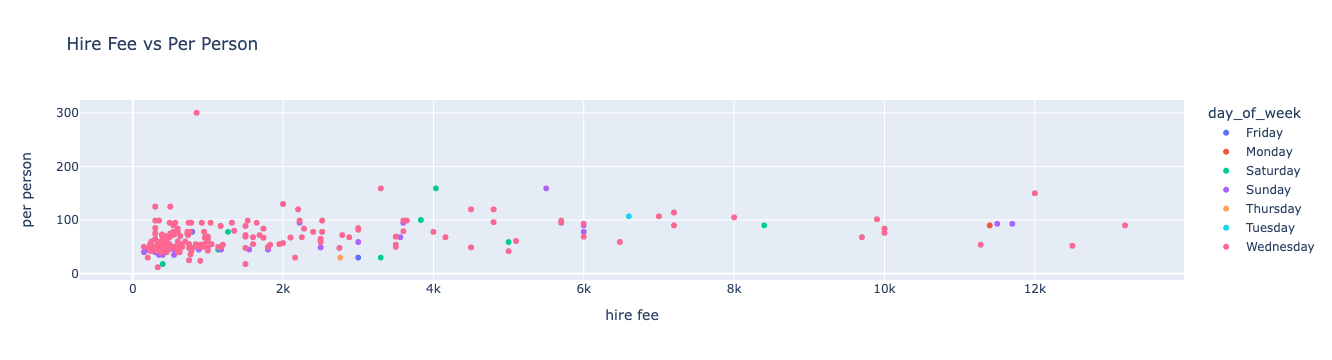

In [189]:
fig = px.scatter(plotting_table, x="hire fee", y="per person", 
                 color = 'day_of_week', title = 'Hire Fee vs Per Person')
fig.show()

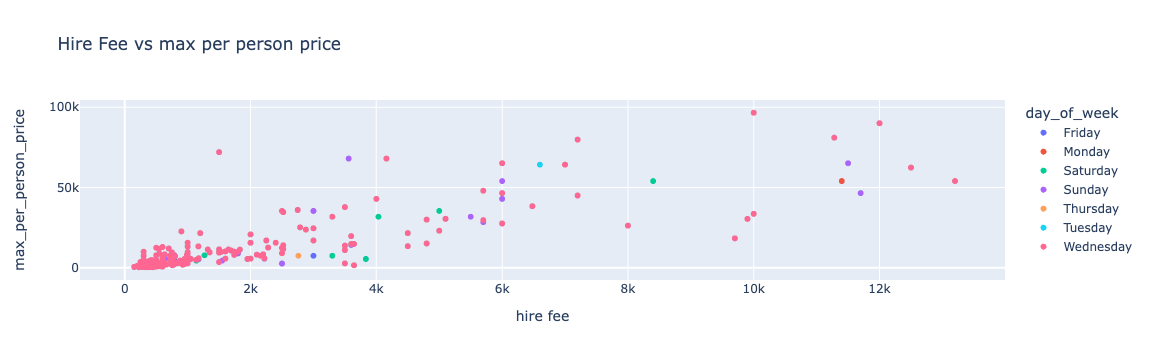

In [190]:
fig = px.scatter(plotting_table, x="hire fee", y="max_per_person_price", 
                 color = 'day_of_week', title = 'Hire Fee vs max per person price')
fig.show()

**Observations:**
- The Hire Fee vs per person plot basically shows no relationship / flat relationship between the variables, there is no clear relationship between hire fee and per person pricing. 
- By multiplying the per person price by the maximum guest capacity, it appears we have created a weak linear relationship. However, this linear relationship has a large spread and as with the conversion between hire price and hire price per hour, we believe the errors that converting these variables would introduce would nullify any advantage of doing so. We will not attempt to convert per person prices to hire fee.